### EE 699 Next Generation Wireless Networks 
- Assignment 02 
- Author: $\text{Rishabh Pomaje}$ 
- Contact: 210020036@iitdh.ac.in

- In this notebook, we will simulate the following queues and compare our empirical findings with the analytic results.
- Scheduling discipline used : _First-In-First-Out_.

#### <font color='red'> Note </font>
- In order to make the below jupyter notebook and code memory and speed efficient, I have reused the variable names. This also provides an additional benefit of consistency of definitions. The downside is that, due to the way jupyter notebook works when reusing variables, the previous data is overwritten, it is highly likely that once you run a cell and go to a previous cell and run it again, it will give erroneous, invalid results. 

- I suggest that you run the complete notebook at once or a cell at a time (but in a flow) to avoid such issues. 

- Due to the extensive simulation period (for better generalization and reaching a steady state), I request you give each queue simulation ~10 seconds to complete.

- The distribution parameters need to be chosen appropriately so as to ensure that the average arrival rate is less than the average departure rate in order to ensure that the queueing system achieves equilibrium. In case, the queue conditions are aberrant from those prescribed the behavior of the queue and the analytical results printed here are **invalid**. 

In [7]:
# Dependencies :
import numpy as np

import matplotlib.pyplot as plt 
%config InlineBackend.figure_format='svg'
# Set global parameters for publication quality
plt.rcParams.update({
    "text.usetex": True,            # Comment if TeX is unavailable on your machine 
    "font.family": "serif",          
})
import seaborn as sns 
sns.set_theme('paper')

In [2]:
# Global functions :
def factorial(n):
    n_fac = 1 
    for i in range(1, n+1):
        n_fac *= i
    
    return n_fac

In [3]:
# Global Definitions :
del_t = 10 ** -3            # smallest time resolution :: in some time units

# del_t = 10 ** -4            # Uncomment for better matching of empirical results*     
total_simul_time = 1000     # In common time units
arrival_rate = 6            # Number of arrivals per unit time
departure_rate = 11         # Number of departure per unit time

# * making del_t smaller will result in closer matching of the analytical results with empirical ones.
# However, the simulation time (execution time) of the code increases. It might require upto 2-3 mins 
# per queue for simluation to complete. 

#### M/M/1 Queue

- Model assumptions:
    1. The arrivals are Poisson with rate $\lambda$.
    2. The service times are exponential with rate $\mu$.
    3. There is a single server and the queue length in not limited. 

- Definition :
    1. $\rho = \frac{\lambda}{\mu}$.

- Note: The arrival rate should be lesser than the departure rate to achieve equilibrium.

In [4]:
def m_m_1_q(simTime, del_t, arrRate, depRate):
    """ 
    Function to simulate an M/M/1 queue.
    Just input 
    1. simTime = Time duration (in seconds) that you would like to simulate the queue for.
    2. arrRate = The arrival rate (per unit time)
    3. depRate = The departure rate (per unit time)

    You will get as output 3 lists.
    1. The state of the queue at time t = 0, delT, 2delT, 3delT, and so on.
    2. The interarrival times.
    3. The departure times.   
    4. The individual "waiting times".(i.e., the time required to wait in the queue + the time to get served). 
    """ 
    # To store the inter-arrival and inter-departure times
    intArrTimes = []
    intDepTimes = [] 
    
    # Timers for arrival and departure
    arrTimer = 0 
    depTimer = 0 

    # Start with an empty queue :: Stores the state of the queue at [t=0, t=delT, t=2delT, t=3delT, ...]
    num_runs = int(simTime / del_t)
    stateHistory = np.zeros(num_runs, dtype=int)            
    
    # Individual customer timer and tracking ID (ID corresponds to the one being served).
    individualTimers = []
    customerID = 0                                

    for i in range(1, num_runs):
        # Flip a coin for an arrival  
        isArrival = np.random.binomial(1, min(1, arrRate * del_t))
        # Flip a coin for departure only if there is atleast one customer
        if stateHistory[i-1] >= 1:
            isDeparture = np.random.binomial(1, min(1, depRate * del_t))
        else:
            isDeparture = 0

        # Update the current state
        stateHistory[i] = stateHistory[i-1] + isArrival - isDeparture
        
        # Increment the timers for both inter-arrival and inter-departure
        arrTimer += del_t
        depTimer += del_t
        # Increment the individual customer timers (for all those in the queue (incl. one in service))
        for idx in range(customerID, len(individualTimers)):
            individualTimers[idx] += del_t

        if isArrival:
            intArrTimes.append(arrTimer)        # Record the inter-arrival timer reading
            arrTimer = 0                        # Reset the timer for the same
            individualTimers.append(0)          # Add a new timer for new customer
        # Similarly for departures
        if isDeparture:
            intDepTimes.append(depTimer)        # Record the inter-departure timer reading
            depTimer = 0                        # Reset the timer for the same
            customerID += 1                     # Move on to the next customer.

    return [stateHistory, intArrTimes, intDepTimes, individualTimers]

In [5]:
queue_history, arr_Times, dep_Times, ind_Times = m_m_1_q(total_simul_time, del_t, arrival_rate, departure_rate)

- Evolution of the state of the system

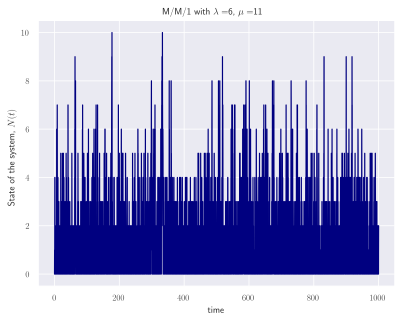

In [6]:
fig, axes = plt.subplots()
axes.plot(del_t * np.arange(int(total_simul_time / del_t)), queue_history, color='navy')
axes.set_xlabel(f'time')
axes.set_ylabel(f'State of the system, $N(t)$')
axes.set_title(f'M/M/1 with $\lambda =${arrival_rate}, $\mu = ${departure_rate}')
fig.savefig(f'simulation_results/mm1_state_history_{arrival_rate}_{departure_rate}.pdf')
fig.savefig(f'simulation_results/mm1_state_history_{arrival_rate}_{departure_rate}.svg', transparent=True)

Observations: 
1. The queue size does not grow without bounds when $\lambda < \mu$. 

- Distribution of Inter-Arrival times

1. Analytical Distribution :
    Inter-arrival times $\overset{i.i.d}{\sim} \text{Exponential}(\lambda)$, where $\lambda$ is the arrival rate.

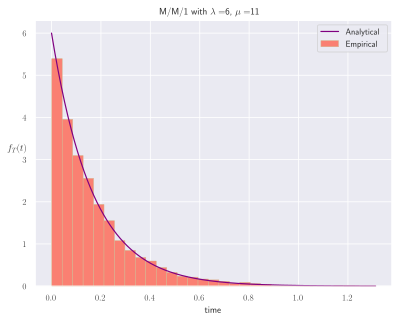

In [7]:
# Ideal PDF of Inter-arrival times :
t_curr_customer = np.linspace(0, np.max(arr_Times), 1000)
analytical_dist = arrival_rate * np.exp(-arrival_rate * t_curr_customer)

fig, axes = plt.subplots()
# Plot the ideal line
axes.plot(t_curr_customer, analytical_dist, color='purple', label='Analytical')
# Plot the empirical line
axes.hist(arr_Times, bins=31, density=True, linewidth=0.5, edgecolor='tan', color='salmon', label='Empirical')
axes.set_xlabel(f'time')
axes.set_ylabel(f'$f_T(t)$', rotation=0)
axes.set_title(f'M/M/1 with $\lambda =${arrival_rate}, $\mu = ${departure_rate}')
axes.legend()
fig.savefig(f'simulation_results/mm1_interArrivalTime_{arrival_rate}_{departure_rate}.pdf')
fig.savefig(f'simulation_results/mm1_interArrivalTime_{arrival_rate}_{departure_rate}.svg', transparent=True)

Observations:
1. The analytical distribution matches the empirically plotted density histogram.
2. The distribution of interarrival times is exponential with rate $\lambda$.

- State Probabilities

Analytical State Probabilities  in equilibrium i.e., when ($\lambda < \mu$),
\begin{align}
p_n &= \mathbb{P}(\text{Queue is in state }n) \\
    &= (1 - \rho) \rho^n\ \quad\ \ldots\ 0 \leq n.
\end{align}

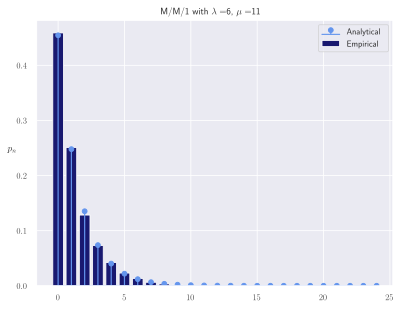

In [8]:
rho = arrival_rate / departure_rate
analytical_dist = []
for i in range(25):
    p_i = (rho ** i) * (1 - rho)
    analytical_dist.append(p_i)

# First, we will extract the unique states and their respective frequencies:
unique_elements, counts = np.unique(queue_history, return_counts=True)

total_count = np.sum(counts)

fig, axes = plt.subplots()
axes.stem(analytical_dist, linefmt='cornflowerblue', basefmt='cornflowerblue', label='Analytical')
axes.bar(unique_elements, counts / total_count, color='midnightblue', label='Empirical')
axes.set_ylabel(f'$p_n$', rotation=0)
axes.set_title(f'M/M/1 with $\lambda =${arrival_rate}, $\mu = ${departure_rate}')
axes.legend()
fig.savefig(f'simulation_results/mm1_stateProbs_{arrival_rate}_{departure_rate}.pdf')
fig.savefig(f'simulation_results/mm1_stateProbs_{arrival_rate}_{departure_rate}.svg', transparent=True)

Observations:
1. For the most part, the fit of the PMF found analytically and that found bar plotting the empirical results match up.
2. The slight mismatch in some states is due to the stochastic (random) variability of the experiment.

- Average number of customers and Variance of number of customers

Analytical Expressions (in equilibrium):
\begin{align}
\text{Mean number of customers} &:       \bar{N} = \frac{\rho}{1 - \rho} \\
\text{Variance of Number of customers} &: \text{var}(N) = \frac{\rho}{(1 - \rho)^2}
\end{align}

In [9]:
mean_empirical = np.mean(queue_history)
mean_analytical = rho / (1 - rho)

print(f'Analytical mean value : {mean_analytical}\n -> Observed mean value : {mean_empirical}')

var_empirical = np.var(queue_history)
var_analytical = rho / ((1 - rho) ** 2)
print(f'Analytical variance : {var_analytical}\n -> Observed variance : {var_empirical}')

Analytical mean value : 1.1999999999999997
 -> Observed mean value : 1.169998
Analytical variance : 2.6399999999999992
 -> Observed variance : 2.388344679996


- Little's Law:
    - The average number of customers in a queue is equal to the product of the arrival rate times the average time spent in the queue.
$\begin{align}
\bar{N} = \lambda \bar{\tau}
\end{align}$

In [10]:
print(f'Average number of customers in the queue = {mean_empirical}')
print(f'lambda * T_avg = {arrival_rate * np.mean(ind_Times)}')

Average number of customers in the queue = 1.169998
lambda * T_avg = 1.1862075025346406


#### M/M/1/N - _Finite buffer case_ 

- Model Assumptions :
    1. Poisson arrivals with rate $\lambda$.
    2. Exponential service times with rate $\mu$.
    3. Single server.
    4. Upper limit on the size of the queue, $N$. Any excess customers will be turned away and will never return back to the queue (to maintain the independent arrivals assumption).

$
\begin{align}
\rho = \frac{\lambda}{\mu}.
\end{align}$ 

In [11]:
def m_m_1_N_q(simTime, del_t, arrRate, depRate, N):
    """ 
    Function to simulate an M/M/1/N queue.
    Just input 
    1. simTime = Time duration (in seconds) that you would like to simulate the queue for.
    2. arrRate = The arrival rate (per unit time)
    3. depRate = The departure rate (per unit time)
    4. N       = Buffer size
    You will get as output 3 lists.
    1. The state of the queue at time t = 0, delT, 2delT, 3delT, and so on.
    2. The interarrival times.
    3. The departure times.    
    """ 
    # To store the inter-arrival and inter-departure times
    intArrTimes = []
    intDepTimes = [] 
    
    # Timers for arrival and departure
    arrivalTimer = 0 
    departureTimer = 0 

    # Start with an empty queue
    num_runs = int(simTime / del_t)
    stateHistory = np.zeros(num_runs, dtype=int) 
    
    # Individual customer timer and tracking ID
    individualTimers = []
    customerID = 0                                

    for i in range(1, num_runs):
        # Flip a coin for arrival  
        if stateHistory[i-1] >= N:
            isArrival = 0                               # Queue full : turn down the new arrival(s)
        else:
            isArrival = np.random.binomial(1, min(1, arrRate * del_t))
        # Flip a coin for departure only if there is atleast one customer
        if stateHistory[i-1] >= 1:
            isDeparture = np.random.binomial(1, min(1, depRate * del_t))
        else:
            isDeparture = 0

        # Update the current state
        stateHistory[i] = stateHistory[i-1] + isArrival - isDeparture

        # Increment the timers for both arrival and departure
        arrivalTimer += del_t
        departureTimer += del_t
        
        for idx in range(customerID, len(individualTimers)):
            individualTimers[idx] += del_t
        
        if isArrival:
            intArrTimes.append(arrivalTimer)                # Record the interarrival time
            arrivalTimer = 0                                # Reset the timer for the same
            individualTimers.append(0)                  # Add a timer for the new customer
        # Similarly for departures
        if isDeparture:
            intDepTimes.append(departureTimer)                # Record the interdeparture time
            departureTimer = 0                                # Reset the timer for the same
            customerID += 1                             # Take on the next customer for service.

    return [stateHistory, intArrTimes, intDepTimes, individualTimers]

In [12]:
del_t = 10 ** -3            # smallest time resolution :: in some time units

# del_t = 10 ** -4            # Uncomment for better matching of empirical results*     
total_simul_time = 1000     # In common time units
arrival_rate = 6            # Number of arrivals per unit time
departure_rate = 11         # Number of departure per unit time

rho = arrival_rate / departure_rate

# * making del_t smaller will result in closer matching of the analytical results with empirical ones.
# However, the simulation time (execution time) of the code increases. It might require upto 2-3 mins 
# per queue for simluation to complete. 

In [13]:
buffer_size = 10                            # Buffer size of the queue
queue_history, arr_Times, dep_Times, ind_Times = m_m_1_N_q(total_simul_time, del_t, arrival_rate, departure_rate, buffer_size)

In [14]:
np.max(queue_history)                       # Maximum size of the queue at any point in time is atmost buffer_size

10

- Evolution of the state of the system

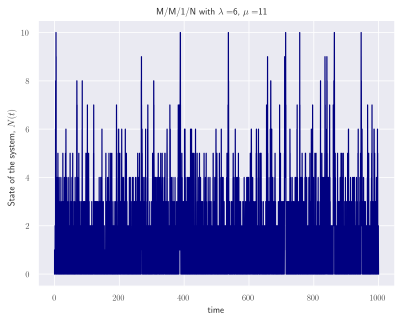

In [15]:
fig, axes = plt.subplots()
axes.plot(del_t * np.arange(int(total_simul_time / del_t)), queue_history, color='navy')
axes.set_xlabel(f'time')
axes.set_ylabel(f'State of the system, $N(t)$')
axes.set_title(f'M/M/1/N with $\lambda = ${arrival_rate}, $\mu = ${departure_rate}')
fig.savefig(f'simulation_results/mm1N_state_history_{arrival_rate}_{departure_rate}.pdf')
fig.savefig(f'simulation_results/mm1N_state_history_{arrival_rate}_{departure_rate}.svg', transparent=True)

- Distribution of Inter-Arrival times

Analytical Distribution :
    Inter-arrival times $\overset{i.i.d}{\sim} \text{Exponential}(\lambda)$

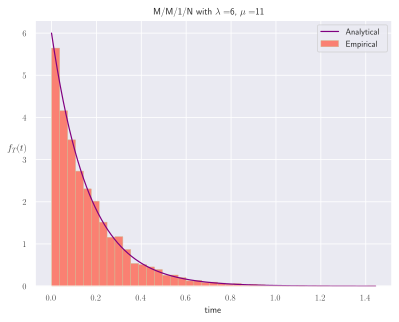

In [16]:
# Ideal PDF of Inter-arrival times :
t_curr_customer = np.linspace(0, max(arr_Times), 1000)
analytical_dist = arrival_rate * np.exp(-arrival_rate * t_curr_customer)

fig, axes = plt.subplots()
# Plot the analytical line
axes.plot(t_curr_customer, analytical_dist, color='purple', label='Analytical')
# Plot the empirical line
axes.hist(arr_Times, bins=41, density=True, linewidth=0.5, edgecolor='tan', color='salmon', label='Empirical')
axes.set_xlabel(f'time')
axes.set_ylabel(f'$f_T(t)$', rotation=0)
axes.set_title(f'M/M/1/N with $\lambda = ${arrival_rate}, $\mu = ${departure_rate}')
axes.legend()
fig.savefig(f'simulation_results/mm1N_interArrivalTime_{arrival_rate}_{departure_rate}.pdf')
fig.savefig(f'simulation_results/mm1N_interArrivalTime_{arrival_rate}_{departure_rate}.svg', transparent=True)

- State Probabilities

Analytical distribution under equilibrium $\lambda < \mu$ :

\begin{align}
    p_n &= \mathbb{P}(\text{system is in state n})\\
        &=  \frac{(1 - \rho) \rho ^ n}{1 - \rho ^{N /+ 1}}\ &&\quad\ \ldots\ 0 \leq n \leq N, \rho \neq 1\\
        &=  \frac{1}{N + 1}\ &&\quad\ \ldots\ 0 \leq n \leq N, \rho = 1\\
\end{align}

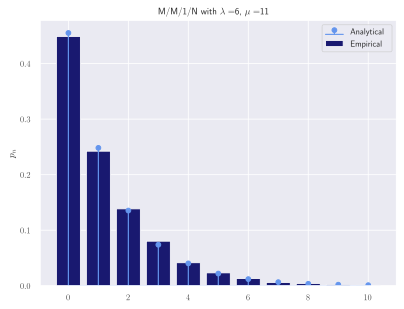

In [17]:
rho = arrival_rate / departure_rate
analytical_dist = []
for i in range(buffer_size+1):
    if rho == 1:
        analytical_dist.append(1 / (buffer_size + 1))
    else:
        p_i = (1 - rho) * (rho ** i) / (1 - (rho ** (buffer_size+1)))
        analytical_dist.append(p_i)

# First, we will extract the unique states and their respective frequencies:
unique_elements, counts = np.unique(queue_history, return_counts=True)

total_count = sum(counts)

fig, axes = plt.subplots()
axes.stem(analytical_dist, linefmt='cornflowerblue', basefmt='cornflowerblue', label='Analytical')
axes.bar(unique_elements, counts / total_count, color='midnightblue', label='Empirical')
axes.set_ylabel(f'$p_n$')
axes.set_title(f'M/M/1/N with $\lambda = ${arrival_rate}, $\mu = ${departure_rate}')
axes.legend()
fig.savefig(f'simulation_results/mm1N_stateProbs_{arrival_rate}_{departure_rate}.pdf')
fig.savefig(f'simulation_results/mm1N_stateProbs_{arrival_rate}_{departure_rate}.svg', transparent=True)

- Blocking probability 
$
\begin{align}
\mathbb{P}_{\text{blocking}} = \mathbb{P}(\text{The queue is full}) = p_N
\end{align}
$

- Analytical blocking probability :
$
\begin{align}
    p_N &= \mathbb{P}(\text{system is in state n})\\
        &=  \frac{(1 - \rho) \rho ^ N}{1 - \rho ^{N + 1}}\ &&\quad\ \ldots\ 0 \leq n \leq N, \rho \neq 1\\
\end{align}
$

**Note** : For the blocking probability to be observed experimentally, it is required that the arrival rate be higher than the departure rate as it would lead to the system running at full capacity for finite intervals.

In [18]:
# Uncomment only if arrival_rate > departure_rate 
N_1 = counts[-1]

print(f'Analytical blocking probability = {((1 - rho) * (rho ** buffer_size)) / (1 - (rho ** (buffer_size + 1)))}')
print(f'-> Observed blocking probability = {N_1 / total_count}')

Analytical blocking probability = 0.001061000439230179
-> Observed blocking probability = 0.000827


#### M/M/$\infty$ - Infinite server system

- Model Assumptions :
    1. Poisson arrival process with rate $\lambda$.
    2. Exponential service times with rate $\mu$.
    3. No limit on queue size. 
    4. $\infty$ amount of server. Equivalently, there is a personal server for every customer that arrives at the queueing facility. 

In [19]:
def m_m_infinite_q(simTime, del_t, arrRate, depRate):
    """ 
    Function to simulate an M/M/infinity queue.
    Just input 
    1. simTime = Time duration (in seconds) that you would like to simulate the queue for.
    2. arrRate = The arrival rate (per unit time)
    3. depRate = The departure rate (per unit time)
    
    You will get as output 3 lists.
    1. The state of the queue at time t = 0, delT, 2delT, 3delT, and so on.
    2. The interarrival times.
    3. The departure times.    
    """ 
    # To store the inter-arrival and inter-departure times
    intArrTimes = []
    intDepTimes = [] 
    
    # Timers for arrival and departure
    arrTimer = 0 
    depTimer = 0 

    # Start with an empty queue
    num_runs = int(simTime / del_t)
    stateHistory = np.zeros(num_runs, dtype=int) 
    
    # Individual customer timer and tracking ID
    individualTimers = []
    customerID = 0                      # For tracking purposes
    activeIDs = []                      # Will keep a record of customers currently at the server 

    for i in range(1, num_runs):
        # Flip a coin for arrival
        isArrival = np.random.binomial(1, min(1, arrRate * del_t))
        # Flip a coin for departure only if there is atleast 1 customer
        if stateHistory[i-1] >= 1:
            # Create a departures list
            isDepartures = [np.random.binomial(1, min(1, depRate * del_t)) for _ in range(stateHistory[i-1])]
        else:
            isDepartures = [] 
        
        # Update the current state
        stateHistory[i] = stateHistory[i-1] + isArrival - np.sum(isDepartures)
        
        # Increment the timers for arrival 
        arrTimer += del_t
        for idx in activeIDs:
            individualTimers[idx] += del_t
        
        # Similarly for departures
        depTimer += del_t
        if np.sum(isDepartures):
            intDepTimes.append(depTimer)
            depTimer = 0                    # Reset the timer  
        
        # Keep only the unserved IDs in the active ID list
        tempIDs = [activeIDs[i] for i in range(len(isDepartures)) if isDepartures[i] == 0]
        activeIDs = tempIDs
        
        # If there was an arrival record the Inter-arrival time and clear the timer (restart)
        if isArrival:
            intArrTimes.append(arrTimer)
            arrTimer = 0
            individualTimers.append(0)      # Add a new customer timer
            activeIDs.append(customerID)    # Add him to the activeIDs
            customerID += 1                 # Next customerID
    
    return [stateHistory, intArrTimes, intDepTimes, individualTimers]

In [20]:
del_t = 10 ** -3                    # smallest time resolution :: in some time units

# del_t = 10 ** -4                      # Uncomment for better matching of empirical results*     
total_simul_time = 1000             # In common time units
arrival_rate = 15                   # Number of arrivals per unit time
departure_rate = 11                 # Number of departure per unit time

rho = arrival_rate / departure_rate

# * making del_t smaller will result in closer matching of the analytical results with empirical ones.
# However, the simulation time (execution time) of the code increases. It might require upto 2-3 mins 
# per queue for simluation to complete. 

In [21]:
queue_history, arr_Times, dep_Times, ind_Times = m_m_infinite_q(total_simul_time, del_t, arrival_rate, departure_rate)

- Evolution of the state of the system

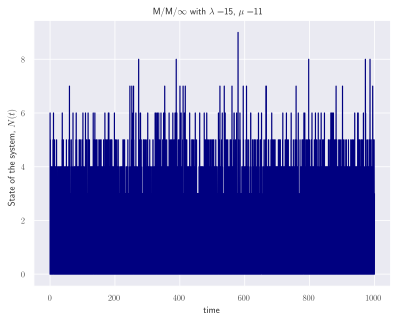

In [22]:
fig, axes = plt.subplots()
axes.plot(del_t * np.arange(int(total_simul_time / del_t)), queue_history, color='navy')
axes.set_xlabel(f'time')
axes.set_ylabel(f'State of the system, $N(t)$')
axes.set_title(f'M/M/$\infty$ with $\lambda = ${arrival_rate}, $\mu = ${departure_rate}')
fig.savefig(f'simulation_results/mmInf_state_history_{arrival_rate}_{departure_rate}.pdf')
fig.savefig(f'simulation_results/mmInf_state_history_{arrival_rate}_{departure_rate}.svg', transparent=True)

- Distribution of Inter-Arrival times

Analytical distribution : Inter-arrival times $\overset{i.i.d}{\sim} \text{Exponential}(\lambda)$

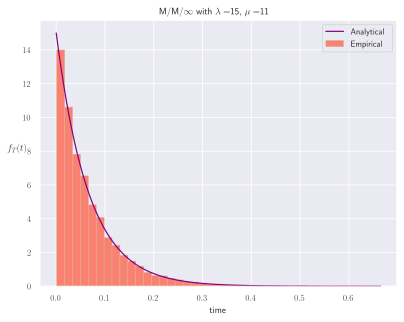

In [23]:
# Ideal PDF of Inter-arrival times :
t_curr_customer = np.linspace(0, np.max(arr_Times), 1000)
analytical_dist = arrival_rate * np.exp(-arrival_rate * t_curr_customer)

fig, axes = plt.subplots()
# Plot the ideal line
axes.plot(t_curr_customer, analytical_dist, color='purple', label='Analytical')
# Plot the empirical line
axes.hist(arr_Times, bins=41, density=True, linewidth=0.5, edgecolor='tan', color='salmon', label='Empirical')
axes.set_xlabel(f'time')
axes.set_ylabel(f'$f_T(t)$', rotation=0)
axes.set_title(f'M/M/$\infty$ with $\lambda = ${arrival_rate}, $\mu = ${departure_rate}')
axes.legend()
fig.savefig(f'simulation_results/mmInf_interArrivalTime_{arrival_rate}_{departure_rate}.pdf')
fig.savefig(f'simulation_results/mmInf_interArrivalTime_{arrival_rate}_{departure_rate}.svg', transparent=True)

- State Probabilities

Analytical state probabilities at equilibrium ($\lambda < \mu$).
\begin{align}
 p_n &= \mathbb{P}(\text{system is in state }n) \\
 &= \frac{\rho^n}{n!} e^{-\rho}\ &&\quad\ \ldots\ n \geq 0.\\
 \text{where, } \rho &= \frac{\lambda}{\mu} 
\end{align}


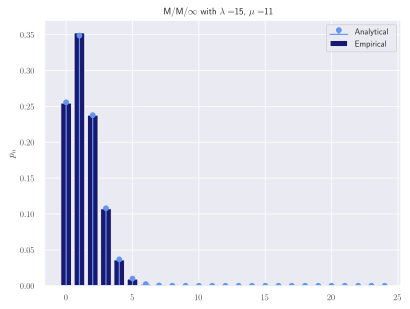

In [24]:
rho = arrival_rate / departure_rate
analytical_dist = []
for i in range(25):
    p_i = (rho ** i) * np.exp(-rho) / factorial(i)
    analytical_dist.append(p_i)

# First, we will extract the unique states and their respective frequencies:
unique_elements, counts = np.unique(queue_history, return_counts=True)

total_count = sum(counts)

fig, axes = plt.subplots()
axes.stem(analytical_dist, linefmt='cornflowerblue', basefmt='cornflowerblue', label='Analytical')
axes.bar(unique_elements, counts / total_count, color='midnightblue', label='Empirical')
axes.set_ylabel(f'$p_n$')
axes.set_title(f'M/M/$\infty$ with $\lambda = ${arrival_rate}, $\mu = ${departure_rate}')
axes.legend()
fig.savefig(f'simulation_results/mmInf_stateProbs_{arrival_rate}_{departure_rate}.pdf')
fig.savefig(f'simulation_results/mmInf_stateProbs_{arrival_rate}_{departure_rate}.svg', transparent=True)

- Average number of customers and Variance of number of customers

In [25]:
mean_empirical = np.mean(queue_history)
mean_analytical = rho 

print(f'Expected mean value : {mean_analytical}\n -> Observed mean value : {mean_empirical}')

var_empirical = np.var(queue_history)
var_analytical = rho 

print(f'Expected variance : {var_analytical}\n -> Observed variance : {var_empirical}')

Expected mean value : 1.3636363636363635
 -> Observed mean value : 1.35687
Expected variance : 1.3636363636363635
 -> Observed variance : 1.3412578031000004


- Departure time (per user) distribution:

In this case, since a customer need not wait in a queue and directly goes into service, it is expected that the time spent in the `queueing facility` is distributed as $\text{Exponential}(\mu)$.

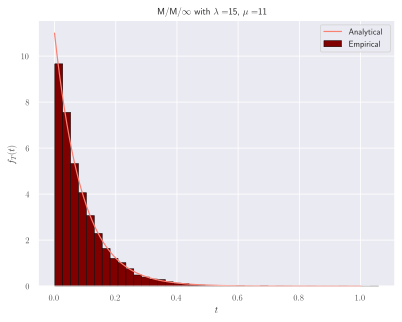

In [26]:
# Analytical Distribution:
x = np.linspace(0, 1, 1000)      
y = departure_rate * np.exp(-departure_rate * x)

fig, axes = plt.subplots()
axes.plot(x, y, color='salmon', label='Analytical')
axes.hist(ind_Times, bins=41, edgecolor='black', linewidth=0.5, color='maroon', density=True, label='Empirical')
axes.set_xlabel(f'$t$')
axes.set_ylabel(f'$f_T(t)$')
axes.legend()
axes.set_title(f'M/M/$\infty$ with $\lambda = ${arrival_rate}, $\mu = ${departure_rate}')
fig.savefig(f'simulation_results/mmInf_response_time_{arrival_rate}_{departure_rate}.pdf')
fig.savefig(f'simulation_results/mmInf_response_time_{arrival_rate}_{departure_rate}.svg', transparent=True)

#### M/M/m - Multiple but Finite Servers

- Model Assumptions :
    1. Poisson arrival process with rate $\lambda$.
    2. Exponential service time with rate $\mu$.
    3. No limit on the queue size.
    4. $m$ servers available.

$
\begin{align}
\rho &= \frac{\lambda}{\mu} \\
\rho' &= \frac{\lambda}{m\mu} 
\end{align}
$

In [8]:
def m_m_m_q(simTime, del_t, arrRate, depRate, numServers):
    """ 
    Function to simulate an M/M/m queue.
    Just input 
    1. simTime = Time duration (in seconds) that you would like to simulate the queue for.
    2. arrRate = The arrival rate (per unit time)
    3. depRate = The departure rate (per unit time)
    4. numServers = Number of servers in the system

    You will get as output 3 lists.
    1. The state of the queue at time t = 0, delT, 2delT, 3delT, and so on.
    2. The interarrival times.
    3. The departure times.    
    """ 
    # Store the inter-arrival and inter-departure times
    intArrTimes = []
    
    # Timers for arrival and departure
    arrTimer = 0 

    # Start with an empty queue
    num_runs = int(simTime / del_t)
    stateHistory = np.zeros(num_runs, dtype=int) 
    
    # Individual customer timer and tracking ID
    individualTimers = []
    customerID = 0                        # For tracking purposes
    activeIDs = []                        # A register of customers currently being served
    waitingIDs = []                       # A register of customers in the waiting "room"

    for i in range(1, num_runs):
        # Flip a coin for arrival
        isArrival = np.random.binomial(1, min(1, arrRate * del_t))
        
        # Flip a coin for departure only if there is atleast 1 customer
        if stateHistory[i-1] >= 1:
            # Create a departures list of indices
            isDepartures = [np.random.binomial(1, min(1, depRate * del_t)) for _ in range(len(activeIDs))]
        else:
            isDepartures = []
        
        # Update the current state
        stateHistory[i] = stateHistory[i-1] + isArrival - np.sum(isDepartures)
        
        # Increment the timers for both arrival and departure
        arrTimer += del_t
        for idx in activeIDs:
            individualTimers[idx] += del_t
        for idx in waitingIDs:
            individualTimers[idx] += del_t

        # Keep only the unserved IDs in the active ID list
        tempIDs = [activeIDs[i] for i in range(len(isDepartures)) if isDepartures[i] == 0]
        activeIDs = tempIDs
        
        # If there was an arrival 
        if isArrival:
            intArrTimes.append(arrTimer)        # Record the Inter-arrival time
            arrTimer = 0                        # Reset the timer
            individualTimers.append(0)          # Add a custom timer for the new customer

            if len(activeIDs) == numServers :
            # No free server :: Put the arrival in the waiting room 
                waitingIDs.append(customerID)
            else:
            # Send to a free server
                activeIDs.append(customerID)
            customerID += 1

    return [stateHistory, intArrTimes, individualTimers]

In [12]:
del_t = 10 ** -3                    # smallest time resolution :: in some time units

# del_t = 10 ** -4                      # Uncomment for better matching of empirical results*     
total_simul_time = 1000             # In common time units
arrival_rate = 6                   # Number of arrivals per unit time
departure_rate = 11                 # Number of departure per unit time


# * making del_t smaller will result in closer matching of the analytical results with empirical ones.
# However, the simulation time (execution time) of the code increases. It might require upto 2-3 mins 
# per queue for simluation to complete. 

In [17]:
num_servers = 5
queue_history, arr_Times, ind_Times = m_m_m_q(total_simul_time, del_t, arrival_rate, departure_rate, num_servers)

- Evolution of the state of the system

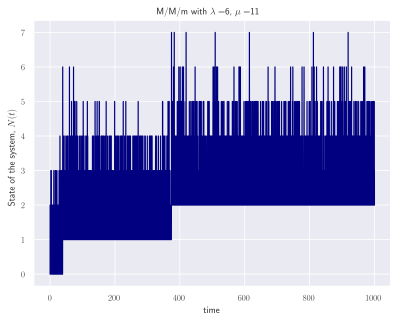

In [18]:
fig, axes = plt.subplots()
axes.plot(del_t * np.arange(int(total_simul_time / del_t)), queue_history, color='navy')
axes.set_xlabel(f'time')
axes.set_ylabel(f'State of the system, $N(t)$')
axes.set_title(f'M/M/m with $\lambda = ${arrival_rate}, $\mu = ${departure_rate}')
fig.savefig(f'simulation_results/mmm_state_history_{arrival_rate}_{departure_rate}.pdf')
fig.savefig(f'simulation_results/mmm_state_history_{arrival_rate}_{departure_rate}.svg', transparent=True)

- Distribution of Inter-Arrival times

Analytical Distribution : Inter-Arrival Times $\overset{i.i.d}{\sim} \text{Exponential}(\lambda)$  

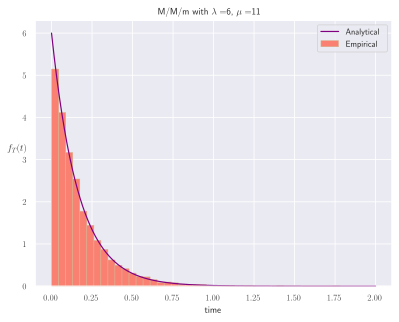

In [15]:
# Analytical PDF of Inter-arrival times :
t_curr_customer = np.linspace(0, 2, 1000)
analytical_dist = arrival_rate * np.exp(-arrival_rate * t_curr_customer)

fig, axes = plt.subplots()
# Plot the analytical PDF
axes.plot(t_curr_customer, analytical_dist, color='purple', label='Analytical')
# Plot the empirical line
axes.hist(arr_Times, bins=41, density=True, linewidth=0.5, edgecolor='tan', color='salmon', label='Empirical')
axes.set_xlabel(f'time')
axes.set_ylabel(f'$f_T(t)$', rotation=0)
axes.set_title(f'M/M/m with $\lambda = ${arrival_rate}, $\mu = ${departure_rate}')
axes.legend()
fig.savefig(f'simulation_results/mmm_interArrivalTime_{arrival_rate}_{departure_rate}.pdf')
fig.savefig(f'simulation_results/mmm_interArrivalTime_{arrival_rate}_{departure_rate}.svg', transparent=True)

- State Probabilities (in equilibrium)

\begin{align} 
            p_0 &= \left[ 1 + \sum_{n=1}^{m-1} \frac{1}{n!} \left( \frac{\lambda}{\mu} \right)^n + \sum_{n=m}^{\infty} \frac{1}{m^{n-m}} \frac{1}{m!} \left( \frac{\lambda}{\mu} \right)^n \right]^{-1}\\
            p_n &= \frac{\lambda^n}{n! \mu^n} p_0 \quad \text{if} \ 1 \leq n < m\\
            p_n &= \frac{\lambda^n}{m^{n-m} m! \mu^n} p_0 \quad \text{if} \ n \geq m.
\end{align}

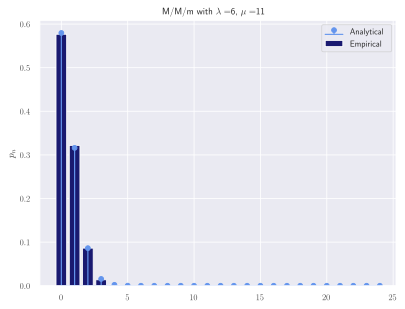

In [16]:
rho = arrival_rate / departure_rate
rho_prime = arrival_rate / (num_servers * departure_rate)
analytical_dist = []
p_0_inv = 1
for n in range(1, num_servers):
    p_0_inv += (1 / factorial(n)) * (rho ** n)
for n in range(num_servers, 2 ** 10):
    # Hopefully the sum will converge 
    p_0_inv += (1 / (num_servers ** (n - num_servers))) * (1 / factorial(num_servers)) * (rho ** n)

p_0 = 1 / p_0_inv

for n in range(num_servers):
    p_i = (1 / factorial(n)) * (rho ** n) * p_0
    analytical_dist.append(p_i)
for n in range(num_servers, 25):
    p_i = (1 / (num_servers ** (n - num_servers))) * (1 / factorial(num_servers)) * (rho ** n) * p_0
    analytical_dist.append(p_i)

# First, we will extract the unique states and their respective frequencies:
unique_elements, counts = np.unique(queue_history, return_counts=True)

total_count = sum(counts)

fig, axes = plt.subplots()
axes.stem(analytical_dist, linefmt='cornflowerblue', basefmt='cornflowerblue', label='Analytical')
axes.bar(unique_elements, counts / total_count, color='midnightblue', label='Empirical')
axes.set_ylabel(f'$p_n$')
axes.set_title(f'M/M/m with $\lambda = ${arrival_rate}, $\mu = ${departure_rate}')
axes.legend()
fig.savefig(f'simulation_results/mmm_stateProbs_{arrival_rate}_{departure_rate}.pdf')
fig.savefig(f'simulation_results/mmm_stateProbs_{arrival_rate}_{departure_rate}.svg', transparent=True)

#### M/G/1 Queue

- Theory 
    - Poisson Arrivals with rate $\lambda$.
    - Service times are distributed arbitrarily but with rate $\mu$.
    - Single server.
    - No limits on queue length.

- Analytical Results
    - $\text{Pollaczek-Khinchin Mean Value Formula}$
    - Let $\rho = \frac{\lambda}{\mu}$
     $\begin{align} 
        \mathbb{E}[n] = \frac{2\rho - \rho^2 + \lambda^2 \sigma_s^2}{2 (1 - \rho)} 
    \end{align}$

- Implementation Details 
    - Slightly different approach from the previous queues has been taken.
    - The modeling of the queue has been started from generating stochastic times or arrival and service. According to these times, the state of the queue, i.e., the number of customers in the queue have been found after every departure.
    - For simplicity, only the $\text{Pollaczek-Khinchin Mean Value Formula}$ has been verified. While I am plotting the state probabilities, I will not be comparing them with the analytical results obtained in the transform domain.

In [1]:
def m_g_1_q(numTotalCustomers, arrRate, servDist, distParams):
    """
    Function to simulate an M/G/1 queue :
    numTotalCustomers = Duration of the simulation = In number of customers
    arrRate           = Parameter of exponential arrival distribution
    depRate           = Parameter of service distribution 
    servDist          = 'exponential', 'deterministic', ''
    distParams*       = Parameters of the distribution of sevice times.
    """
    # Generate the interarrival times :: Markovian Process
    intArrTimes = np.random.exponential(1/arrRate, numTotalCustomers-1)

    # Arrival time stamps (Observation begins when first customer arrives)
    arrTimeStamps = np.append([0], np.cumsum(intArrTimes))

    # Service Times for each of the customers 
    if servDist == 'exponential':
        indServiceTimes = np.random.exponential(1/distParams, numTotalCustomers)
    elif servDist == 'deterministic':   
        indServiceTimes = distParams * np.ones(numTotalCustomers)
    elif servDist == 'gamma':   
        indServiceTimes = np.random.gamma(distParams[0], distParams[1], numTotalCustomers)
    elif servDist == 'uniform': 
        indServiceTimes = np.random.uniform(distParams[0], distParams[1], numTotalCustomers)
    else :
        print(f'Error: Service Time distribution not available.')
        return None

    # Finding the time stamp at which each person departed
    depTimeStamps = [indServiceTimes[0]]
    for i in range(1, numTotalCustomers):
        # if arrTimeStamps[i] > depTimeStamps[i - 1] :
        #     depTimeStamps.append(arrTimeStamps[i] + indServiceTimes[i])
        # else:
        #     depTimeStamps.append(depTimeStamps[i-1] + indServiceTimes[i])
        depTimeStamps.append(max(arrTimeStamps[i], depTimeStamps[i-1]) + indServiceTimes[i])

    stateHistory = []
    for i, dep_time in enumerate(depTimeStamps):
        # Count arrivals before the current departure time
        arrivals_before_dep = sum(1 for arr_time in arrTimeStamps if arr_time < dep_time)
        
        # Calculate number of people still in the queue after each departure
        stateHistory.append(arrivals_before_dep - i - 1)

    return [stateHistory, intArrTimes, indServiceTimes]

# Auxilary functions
def argmax_less_than(searchArr, threshold):
    max_value = None
    max_index = -1
    
    for i, element in enumerate(searchArr):
        if element < threshold: 
            if max_value is None or element > max_value:
                max_value = element
                max_index = i
    
    return max_index

def PolkChinMVformula(rho, lmbda, sig2):
    """ 
    Function to calculate the Pollaczek-Khinchin Mean Value Formula.
    """
    numerator = (2 * rho) - (rho ** 2) + ((lmbda ** 2) * sig2)
    denominator = 2 * (1 - rho)
    return numerator / denominator

In [2]:
del_t = 10 ** -3                        # smallest time resolution :: in some time units

# del_t = 10 ** -4                      # Uncomment for better matching of empirical results*     
total_simul_time = 1000                 # In common time units
arrival_rate = 6                        # Number of arrivals per unit time
departure_rate = 11                     # Number of departures per unit time

rho = arrival_rate / departure_rate

# * Making del_t smaller will result in a closer match of the analytical results with empirical ones.
# However, the simulation time (execution time) of the code increases. It might require 2-3 mins 
# per queue for simulation to complete. 

In [3]:
num_customers_obs = 10 ** 4 
queue_history, _, _ =  m_g_1_q(num_customers_obs, arrival_rate, 'exponential', departure_rate)

rho = arrival_rate / departure_rate
print(f'Empirical Mean State: {np.mean(queue_history)}')
print(f'-> Analytical Mean State: {PolkChinMVformula(rho, arrival_rate, 1 / (departure_rate ** 2))}')

NameError: name 'np' is not defined

In [ ]:
num_customers_obs = 10 ** 4 
queue_history, _, _ =  m_g_1_q(num_customers_obs, arrival_rate, 'deterministic', 1 / departure_rate)

rho = arrival_rate / departure_rate 
print(f'Empirical Mean State: {np.mean(queue_history)}')
print(f'-> Analytical Mean State: {PolkChinMVformula(rho, arrival_rate, 0)}')

Empirical Mean State: 0.863
-> Analytical Mean State: 0.8727272727272727


In [ ]:
num_customers_obs = 10 ** 4 
k, theta = 0.5, 0.1
queue_history, _, _ =  m_g_1_q(num_customers_obs, arrival_rate, 'gamma', [k, theta])

mean_time = k * theta
var_time = k * (theta ** 2)
rho = arrival_rate * mean_time 
print(f'Empirical Mean State: {np.mean(queue_history)}')
print(f'-> Analytical Mean State: {PolkChinMVformula(rho, arrival_rate, var_time)}')

Empirical Mean State: 0.5102
-> Analytical Mean State: 0.49285714285714294


In [ ]:
num_customers_obs = 10 ** 4 
lowlim, uplim = 0, 0.1
queue_history, _, _ =  m_g_1_q(num_customers_obs, arrival_rate, 'uniform', [lowlim, uplim])

mean_time = (lowlim + uplim) / 2
var_time = ((uplim - lowlim) ** 2) / 12
print(f'Empirical Mean State: {np.mean(queue_history)}')
print(f'-> Analytical Mean State: {PolkChinMVformula(rho, arrival_rate, var_time)}')

Empirical Mean State: 0.3848
-> Analytical Mean State: 0.3857142857142858
